# Assignment 1

**Lecturer**: Vincent Claes<br>
**Authors:** Bryan Honof, Jeffrey Gorissen<br>
**Start Date:** 19/10/2018
    
**Objective:** Visualize and predict the future temperatures via ARIMA

## Table of contents

1. [Import Libraries](#Import-Libraries)
2. [Get Data](#Get-Data)  
3. [Wrangle the Data](#Wrangle-the-Data)<br>
    a. [restructure the dataframe](#restructure-the-dataframe)<br>
    b. [create a timeseries dataframe](#create-a-timeseries-dataframe)
4. [A bit of Exploratory Data Analysis (EDA)](#EDA) 
5. [Fixing the errors in the data](#fixing)
6. [Trends and Seasonality in Time Series Data](#Trends-and-Seasonality-in-Time-Series-Data)<br>
    a. [Identifying Trends in Time Series](#Identifying-Trends-in-Time-Series)
7. [Seasonal Patterns in Time Series Data](#Seasonal-Patterns-in-Time-Series-Data)<br>
    a. [First-order differencing](#First-order-differencing)<br>
    b. [Autocorrelation](#Autocorrelation)
8. [Creating The ARIMA Model](#Creating-The-ARIMA-Model)

## 1. Import Libraries <a name="Import-Libraries"></a>

To start, we will import some package: in this case, we will make use of ```numpy```, ```pandas```, ```matplotlib``` and ```seaborn```.

Additionally since we want to display our plots in this Jupyter Notebook, we can make use of the IPython magic by adding ```%matplotlib inlince``` to this cell.

In [41]:
# Import packages
import warnings
import itertools
import subprocess
import psycopg2

import pandas            as pd
import numpy             as np
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import seaborn           as sns

sns.set()
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Get Data <a name="Get-Data"></a>

We have 2 options here toggled by the 'in_school' variable.
If this variable is set to True we will obtain our data by pulling a JSON object from the heroku webserver.
If it is set to False we will obtain it by first connecting to the Heroku PostgreSQL database and applying a simple SQL querry to that database.

In [2]:
in_school = True

if (True == in_school):
    # Get the data from the web route because school blocks the port used by the database :)
    
    url  = 'https://pxl-ss.herokuapp.com/api/temps'
    data = pd.read_json(url, orient='columns')
else:
    # Get the data directly from the database
    
    HEROKU_APP_NAME = "pxl-ss"
    TABLE_NAME      = "Temperature"

    conn_info = subprocess.run(["heroku", "config:get", "DATABASE_URL", "-a", HEROKU_APP_NAME], stdout = subprocess.PIPE)
    connuri   = conn_info.stdout.decode('utf-8').strip()

    engine     = create_engine(connuri)
    raw_engine = engine.raw_connection()

    data = pd.read_sql_query("SELECT * FROM Temperature;", raw_engine)

In [3]:
# Make sure we recieved the data correctly by printing out the head()
data.head(5)

,creation_date,id,place,value
0,2018-11-10T23:38:44.453789+00:00,1,"Lat:51.037460, Long: 5.301590",21.48
1,2018-11-10T23:53:53.134313+00:00,2,"Lat:51.037460, Long: 5.301590",19.48
2,2018-11-10T23:53:57.457321+00:00,3,"Lat:51.037460, Long: 5.301590",20.60
3,2018-11-10T23:56:10.690055+00:00,4,"Lat:51.037460, Long: 5.301590",20.45
4,2018-11-10T23:58:49.577553+00:00,5,"Lat:51.037460, Long: 5.301590",20.76


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 4 columns):
creation_date    693 non-null object
id               693 non-null int64
place            693 non-null object
value            693 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 21.7+ KB


By looking at the ```data.info()``` output we can see that we have multiple columns we are not interested. We can also see that the ```creation_date``` column is a ```object``` type but we want it to it to be of type ```Datetime```. We will take care of both of these problems in the next steps.

## 3. Wrangle the Data <a name="Wrangle-the-Data"></a>

The first thing we want to do is get rid of the columns we are not interested in.

In this case we are only interested in the ```creation_date``` column and the ```value``` column. We will also rename these to column to ```dateTime``` and ```temperature``` just for ease of use.

### a. restructure the dataframe <a name="restructure-the-dataframe">

In [5]:
# Filter out all the columsn except for 'creation_date' & 'value'
# Rename those columns to 'dateTime' & temperature
df = pd.DataFrame(data, columns = ['creation_date', 'value'])
df.columns = ['dateTime', 'temperature']

# Double check the results of the reassignment
df.head(5)

,dateTime,temperature
0,2018-11-10T23:38:44.453789+00:00,21.48
1,2018-11-10T23:53:53.134313+00:00,19.48
2,2018-11-10T23:53:57.457321+00:00,20.60
3,2018-11-10T23:56:10.690055+00:00,20.45
4,2018-11-10T23:58:49.577553+00:00,20.76


### b. create a timeseries dataframe <a name="create-a-timeseries-dataframe">
    
Since we want a time series dataframe we still have to set the ```dateTime``` column to be our index. But to do this it still has to be converted to type type of ```Datetime``` first.

In [6]:
# Convert the creation_date column to datetime64
df['dateTime'] = pd.to_datetime(df.dateTime)
# Convert the value column to float
df['temperature'] = pd.to_numeric(df.temperature)

# Set the dateTime column as index
df.set_index(['dateTime'], inplace=True)

# Double check the results
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 693 entries, 2018-11-10 23:38:44.453789 to 2018-11-18 13:39:12.493675
Data columns (total 1 columns):
temperature    693 non-null float64
dtypes: float64(1)
memory usage: 10.8 KB


## 4. A bit of Exploratory Data Analysis (EDA) <a name="EDA"></a>

In [7]:
df.head(5)

,temperature
dateTime,
2018-11-10 23:38:44.453789,21.48
2018-11-10 23:53:53.134313,19.48
2018-11-10 23:53:57.457321,20.60
2018-11-10 23:56:10.690055,20.45
2018-11-10 23:58:49.577553,20.76


We can see in the plot that there is some missing data (by the plummeting line).

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 693 entries, 2018-11-10 23:38:44.453789 to 2018-11-18 13:39:12.493675
Data columns (total 1 columns):
temperature    693 non-null float64
dtypes: float64(1)
memory usage: 10.8 KB


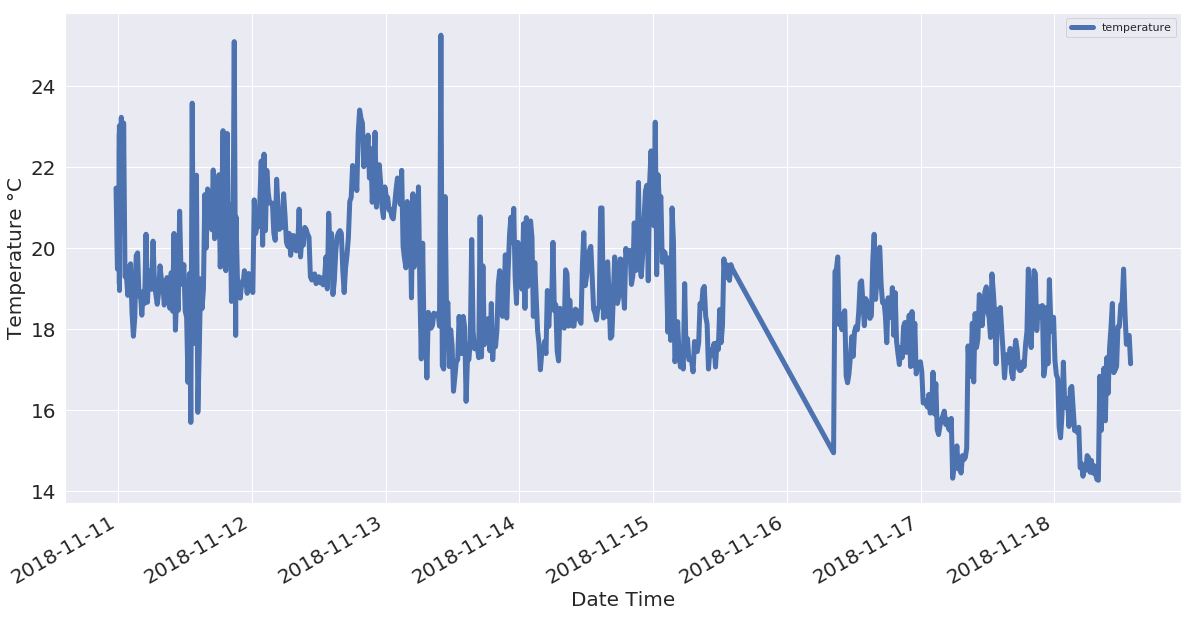

In [9]:
df.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

we can see immediately that there is something wierd with that data.<br>
Something went wrong around 2018-11-15 - 2018-11-16. (I know the device that collected the data lost internet connection so that is what went wrong :D)<br>

## 5. Fixing the errors in the data <a name="fixing"></a>

Like we saw in the previous step something went wrong when we were collecting our data.<br>
To fix this we are going to do 2 things.
* downsample our data to have a frequency of 15mins
* get rid of all NaN values

In [10]:
# Change the frequency to 15mins
df_resample = df.resample('15T').mean()

In [11]:
df_resample.head()

,temperature
dateTime,
2018-11-10 23:30:00,21.480000
2018-11-10 23:45:00,20.322500
2018-11-11 00:00:00,20.906316
2018-11-11 00:15:00,21.330000
2018-11-11 00:30:00,22.177500


In [12]:
df_resample.isnull().sum()

temperature    75
dtype: int64

This output tells us that there are (at the moment of writing this) 75 NaN values in our dataframe

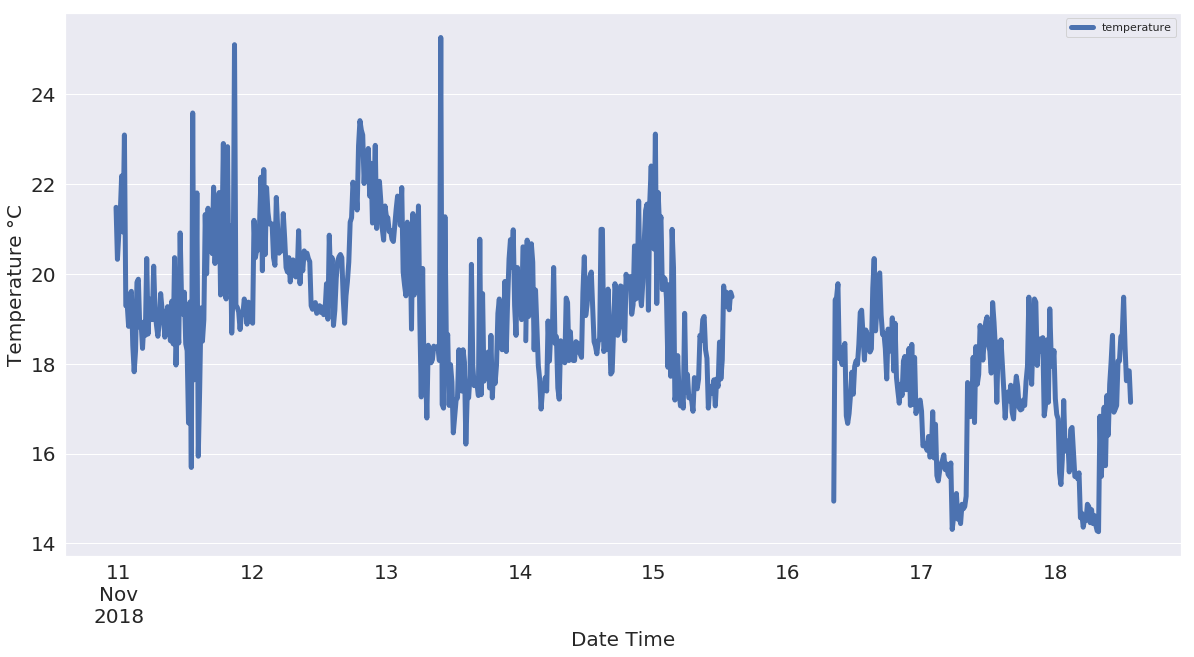

In [13]:
df_resample.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

By plotting out the dataframe we can clearly see the missing data.

In [14]:
df_resample = df_resample.interpolate(method='linear')

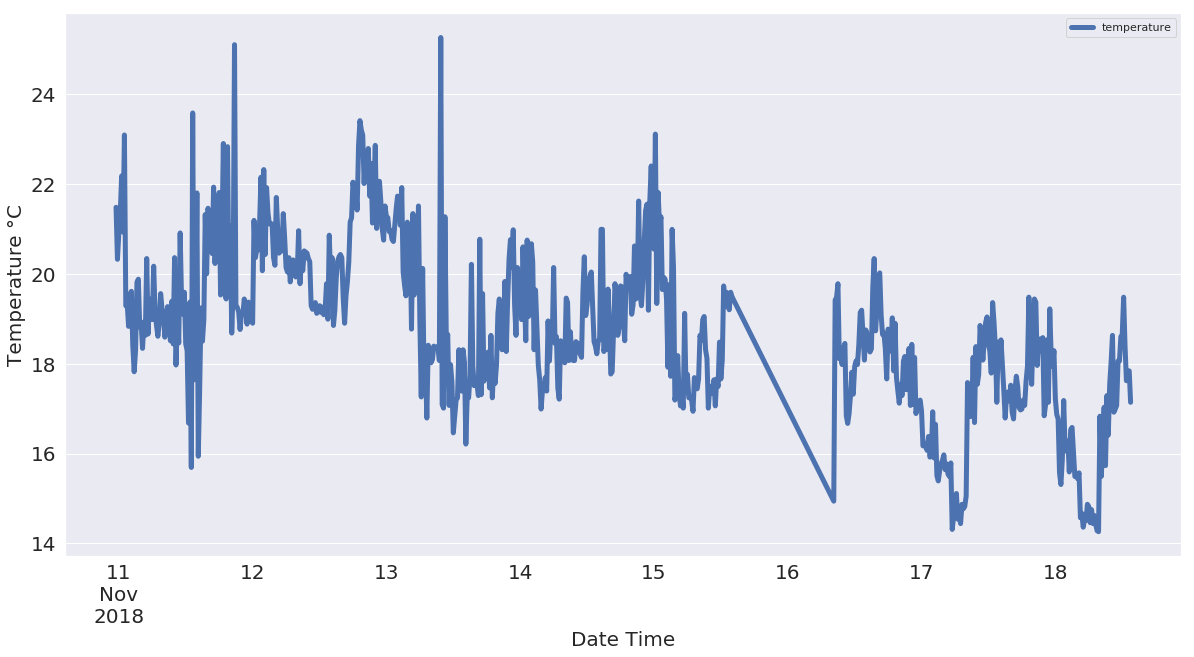

In [15]:
df_resample.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

But guys... this chart looks exactly the same like the one you first said was wrong! Do you even know what you are doing???

Well yes they look identical but the difference between the 2 is that this one accually has values for each index. The previous chart skipped some indexes.

In [16]:
df = df_resample

## 6. Trends and Seasonality in Time Series Data <a name="Trends-and-Seasonality-in-Time-Series-Data"></a>

### a. Identifying Trends in Time Series <a name="Identifying-Trends-in-Time-Series"></a>

There are several ways to think about identifying trends in time series. One popular way is by taking a rolling average, which means that, for each time point, you take the average of the points on either side of it. Note that the number of points is specified by a window size, which you need to choose.

What happens then because you take the average is it tends to smooth out noise and seasonality. Check out this rolling average of ```'temperature'``` using the built-in ```pandas``` methods.

In [21]:
df_rolling = df.rolling(15).mean()

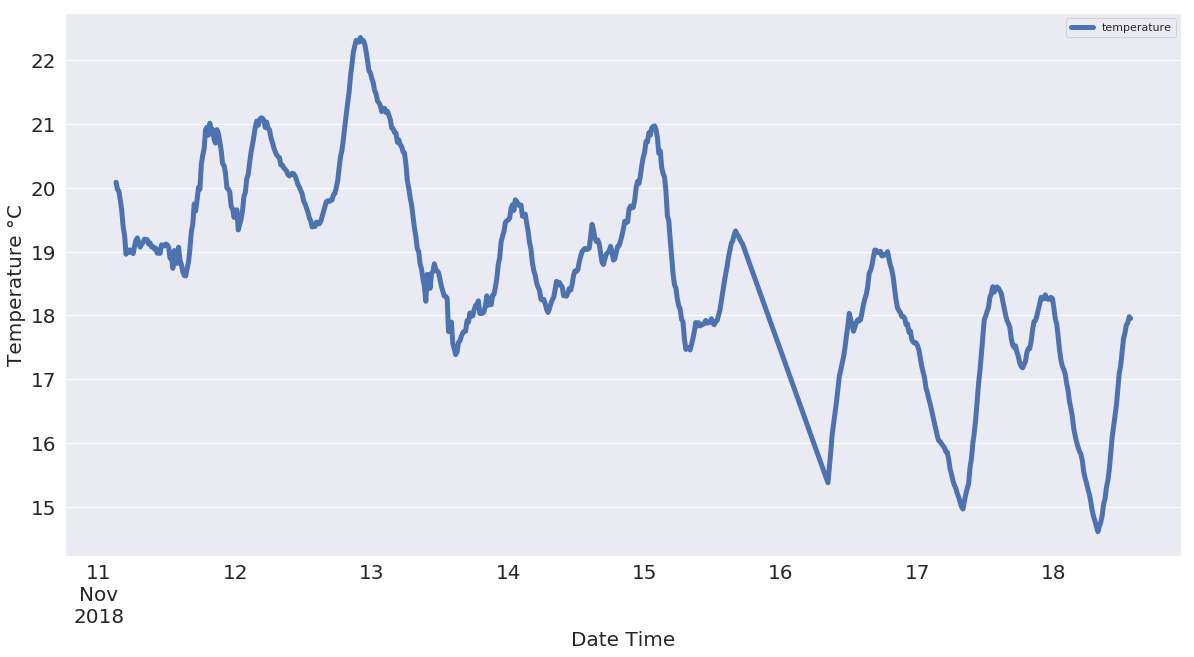

In [22]:
df_rolling.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

Now you have the trend that you're looking for! You have removed most of the seasonality compared to the previous plot.

## 7. Seasonal Patterns in Time Series Data<a name="Seasonal-Patterns-in-Time-Series-Data"></a>

One way to think about the seasonal components to the time series of your data is to remove the trend from a time series, so that you can more easily investigate seasonality. To remove the trend, you can subtract the trend you computed above (rolling mean) from the original signal. This, however, will be dependent on how many data points you averaged over.

Another way to remove the trend is called "differencing", where you look at the difference between successive data points (called "first-order differencing", because you're only looking at the difference between one data point and the one before it).

### a. First-order differencing<a name="First-order-differencing"></a>

You can use pandas and the ```diff()``` and ```plot()``` methods to compute and plot the first order difference of the ```'temperature'``` Series:

In [25]:
df_diff = df.diff()

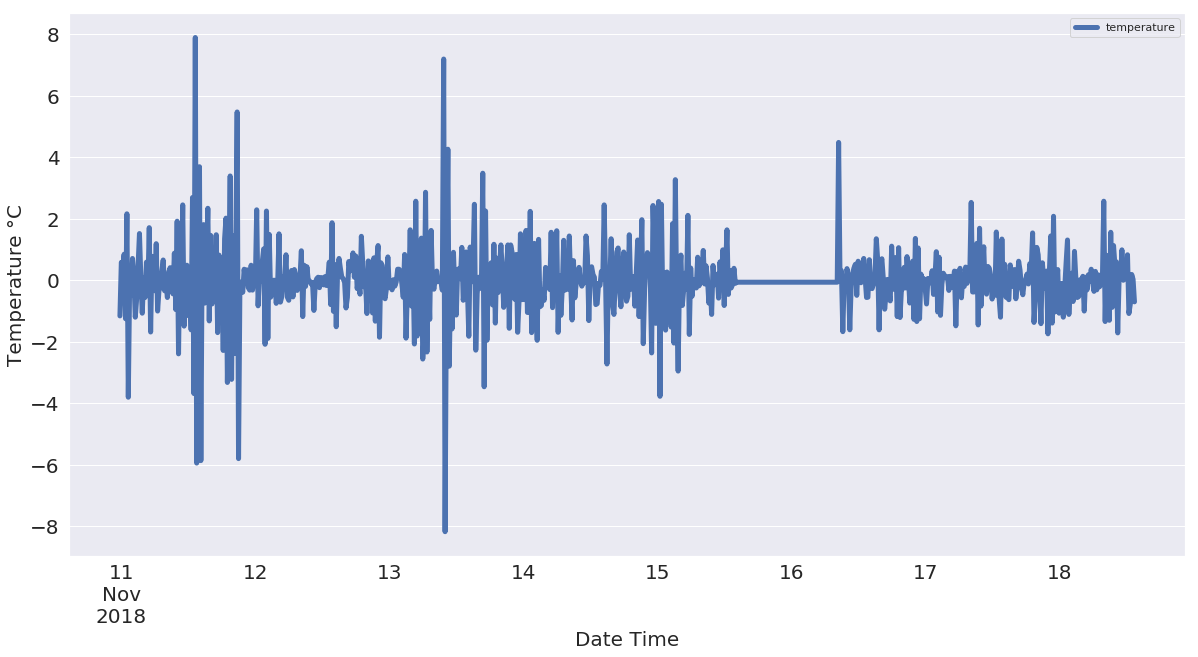

In [26]:
df_diff.plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date Time', fontsize=20)
plt.ylabel('Temperature °C', fontsize=20)
plt.show()

### b. Autocorrelation<a name="Autocorrelation"></a>

A time series is periodic if it repeats itself at equally spaced intervals, say, every 15 minutes.

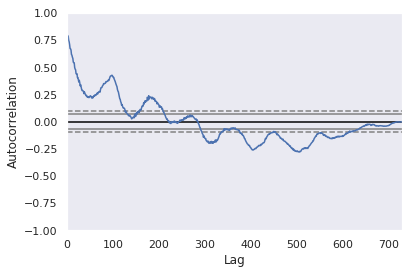

In [37]:
pd.plotting.autocorrelation_plot(df)

## 8. Creating The ARIMA Model<a name="Creating-The-ARIMA-Model"></a>

In [38]:
from statsmodels.tsa.arima_model import ARIMA

In [43]:
# fit model
model = ARIMA(df, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.temperature   No. Observations:                  728
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1007.875
Method:                       css-mle   S.D. of innovations              0.966
Date:                Sun, 18 Nov 2018   AIC                           2029.749
Time:                        15:15:54   BIC                           2061.881
Sample:                    11-10-2018   HQIC                          2042.148
                         - 11-18-2018                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0048      0.015     -0.330      0.741      -0.033       0.024
ar.L1.D.temperature    -0.7063      0.037    -19.061      0.000      -0.779      -0.634
ar.L2.D.temperat

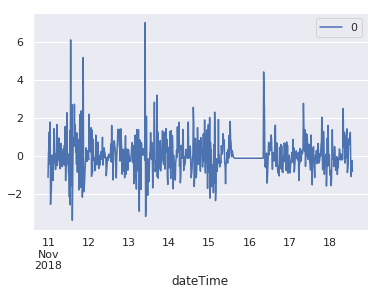

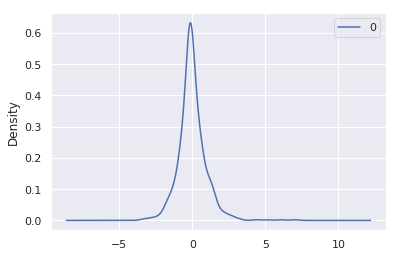

                0
count  728.000000
mean    -0.000832
std      0.966712
min     -3.411730
25%     -0.461612
50%     -0.138197
75%      0.408809
max      6.996365


In [46]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
from sklearn.metrics import mean_squared_error

X = df.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=17.210155, expected=17.059178
predicted=17.147496, expected=16.996849
predicted=17.084838, expected=16.934521
predicted=17.022181, expected=16.872192
predicted=16.959526, expected=16.809863
predicted=16.896872, expected=16.747534
predicted=16.834220, expected=16.685205
predicted=16.771568, expected=16.622877
predicted=16.708919, expected=16.560548
predicted=16.646271, expected=16.498219
predicted=16.583624, expected=16.435890
predicted=16.520978, expected=16.373562
predicted=16.458334, expected=16.311233
predicted=16.395691, expected=16.248904
predicted=16.333050, expected=16.186575
predicted=16.270410, expected=16.124247
predicted=16.207771, expected=16.061918
predicted=16.145133, expected=15.999589
predicted=16.082497, expected=15.937260
predicted=16.019862, expected=15.874932
predicted=15.957228, expected=15.812603
predicted=15.894596, expected=15.750274
predicted=15.831965, expected=15.687945
predicted=15.769335, expected=15.625616
predicted=15.706707, expected=15.563288
